<a href="https://colab.research.google.com/github/xandrisx/pytorch-weather-deep-learning/blob/main/pytorch_weather_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Mappák létrehozásáért felelős kód
import os

# Időjárási kategóriák listája
weather_categories = ['cloudy', 'rainy', 'sunny', 'sunrise']

# Alap mappa útvonala
base_dir = '/content/weather_images'

# Mappák létrehozása
for category in weather_categories:
    category_dir = os.path.join(base_dir, category)
    os.makedirs(category_dir, exist_ok=True)
    print(f'Mappa létrehozva: {category_dir}')

print('\nÖsszes mappa sikeresen létrehozva.')



Mappa létrehozva: /content/weather_images/cloudy
Mappa létrehozva: /content/weather_images/rainy
Mappa létrehozva: /content/weather_images/sunny
Mappa létrehozva: /content/weather_images/sunrise

Összes mappa sikeresen létrehozva.


In [3]:
#Ez a kód megjeleníti, hogy hány db fájlt tartalmaznak az adott mappák
import os

base_dir = '/content/weather_images'
weather_categories = ['cloudy', 'rainy', 'sunny', 'sunrise']

for category in weather_categories:
    category_dir = os.path.join(base_dir, category)
    files = os.listdir(category_dir)
    print(f"{category}: {len(files)} fájl")


cloudy: 0 fájl
rainy: 0 fájl
sunny: 0 fájl
sunrise: 0 fájl


In [4]:
import os
import shutil

# Az FWID adatkészlet feltételezett helye
fwid_dir = '/content/FWID'  # Módosítsa ezt az útvonalat, ha szükséges

base_dir = '/content/weather_images'
weather_categories = ['cloudy', 'rainy', 'sunny', 'sunrise']

for category in weather_categories:
    src_dir = os.path.join(fwid_dir, category)
    dst_dir = os.path.join(base_dir, category)

    # Ellenőrizzük, hogy a forrásmappa létezik-e
    if not os.path.exists(src_dir):
        print(f"A {src_dir} mappa nem található.")
        continue

    # Másoljuk át a képeket
    for filename in os.listdir(src_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')):
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(dst_dir, filename)
            shutil.copy2(src_file, dst_file)

    # Ellenőrizzük a másolt fájlok számát
    copied_files = len([name for name in os.listdir(dst_dir) if os.path.isfile(os.path.join(dst_dir, name))])
    print(f"{category}: {copied_files} kép másolva")


A /content/FWID/cloudy mappa nem található.
A /content/FWID/rainy mappa nem található.
A /content/FWID/sunny mappa nem található.
A /content/FWID/sunrise mappa nem található.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


Epoch [1/2], Loss: 0.2994
Epoch [2/2], Loss: 0.3309


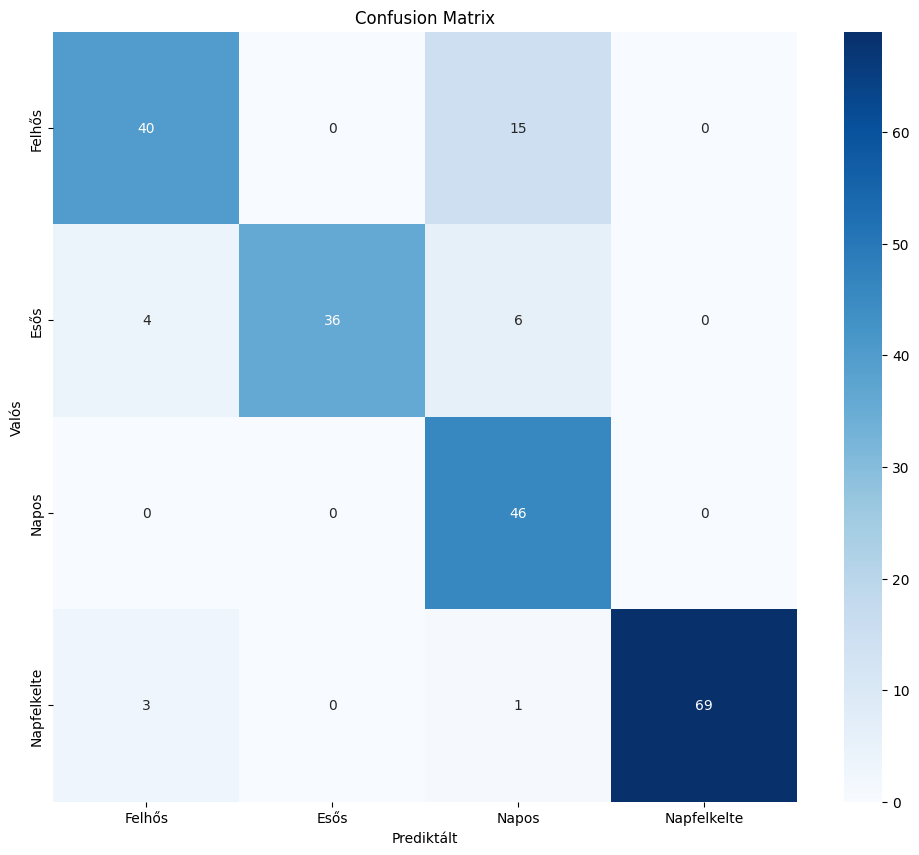

Accuracy: 0.87
Felhős pontossága: 0.73
Esős pontossága: 0.78
Napos pontossága: 1.00
Napfelkelte pontossága: 0.95


In [5]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Adatok betöltése és előkészítése
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Feltételezzük, hogy a képek megfelelő mappákban vannak
data_dir = "/content/weather_images"
dataset = ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modell definiálása
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 osztály: felhős, esős, napos, napfelkelte

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Veszteségfüggvény és optimalizáló
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tanítás
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Tesztelés és confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Felhős', 'Esős', 'Napos', 'Napfelkelte']
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediktált')
plt.ylabel('Valós')
plt.title('Confusion Matrix')
plt.show()

# Accuracy kiszámítása
accuracy = np.trace(cm) / np.sum(cm)
print(f'Accuracy: {accuracy:.2f}')

# Osztályonkénti pontosság
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'{class_names[i]} pontossága: {acc:.2f}')
